In [1]:
import sys

In [2]:
sys.path.insert(0,'../')

In [3]:
import pyathena as pa

In [4]:
from pyathena.tigress_ncr.load_sim_tigress_ncr import LoadSimTIGRESSNCR

In [5]:
orig_dir="/projects/EOSTRIKE/TIGRESS-NCR/R8_4pc_NCR.full.xy2048.eps0.np768.has/"   # path to the original data
save_dir="/scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR" # path to the directory where temporary files to be stored
s=LoadSimTIGRESSNCR(orig_dir,verbose=True,savdir=save_dir)

[LoadSimTIGRESSNCR-INFO] basedir: /projects/EOSTRIKE/TIGRESS-NCR/R8_4pc_NCR.full.xy2048.eps0.np768.has
[LoadSimTIGRESSNCR-INFO] savdir: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR
[LoadSimTIGRESSNCR-INFO] load_method: xarray
[FindFiles-INFO] athinput: /projects/EOSTRIKE/TIGRESS-NCR/R8_4pc_NCR.full.xy2048.eps0.np768.has/out.txt
[FindFiles-INFO] athena_pp: False
[FindFiles-INFO] problem_id: R8_4pc_NCR
[FindFiles-INFO] vtk in tar: /projects/EOSTRIKE/TIGRESS-NCR/R8_4pc_NCR.full.xy2048.eps0.np768.has/vtk nums: 200-500
[FindFiles-WARNING] Vtk file size is not unique.
[FindFiles-WARNING] vtk num: 0, size [MB]: 8834
[FindFiles-WARNING] vtk num: 1, size [MB]: 8834
[FindFiles-WARNING] vtk num: 2, size [MB]: 8834
[FindFiles-WARNING] vtk num: 3, size [MB]: 8834
[FindFiles-WARNING] vtk num: 4, size [MB]: 8834
[FindFiles-WARNING] vtk num: 5, size [MB]: 8834
[FindFiles-WARNING] vtk num: 6, size [MB]: 8834
[FindFiles-WARNING] vtk num: 7, size [MB]: 8834
[FindFiles-WARNING] vtk num: 8, size [MB]: 883

xi_CR0 not found. Use 2e-16.


In [6]:
# snapshot number to be loaded
num = s.nums[-1]
prj = s.read_prj(num)
sp = s.load_starpar_vtk(num)

[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/prj/prj_0500.p
[LoadSimTIGRESSNCR-INFO] [load_starpar_vtk]: R8_4pc_NCR.0500.starpar.vtk. Time: 499.685700


# Xarray
* https://xarray.dev/
* full documentation: https://docs.xarray.dev/en/stable/
* tutorial: https://tutorial.xarray.dev/intro.html

* Read this: https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html
* and this: https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataset

## Now, let's convert the projection data into Xarray dataset

I will store each 2D data field in `x` and `y` to `xarray.DataArray` and the collection of the projected data to `xarray.Dataset` with additional coordinates `time`. To do this, we need to first construct coordinates array.

## Construct coordinates array

In [7]:
# create coordinates array
# the basic domain information is stored in "domain" member
s.domain

{'Nx': array([ 256,  256, 1536]),
 'ndim': 3,
 'le': array([ -512,  -512, -3072]),
 're': array([ 512,  512, 3072]),
 'Lx': array([1024, 1024, 6144]),
 'dx': array([4., 4., 4.]),
 'center': array([0., 0., 0.]),
 'time': None}

In [8]:
# given that we are using a uniform, Cartesian grid, it is easy to construct coordinates
# cell face coordinates
xfc = [np.linspace(s.domain["le"][i],s.domain["re"][i],s.domain["Nx"][i]+1) for i in range(3)]
# cell center coordinates
xcc = [0.5*(fc_[1:]+fc_[:-1]) for fc_ in xfc]

In [9]:
print(f"cell edge position in the x-direction starts from {xfc[0][0]} to {xfc[0][-1]}")
print(f"cell center position in the x-direction starts from {xcc[0][0]} to {xcc[0][-1]}")

cell edge position in the x-direction starts from -512.0 to 512.0
cell center position in the x-direction starts from -510.0 to 510.0


## numpy.ndarray to Xarray.DataArray

In [10]:
type(prj["z"]["Sigma_gas"])

numpy.ndarray

In [11]:
import xarray as xr
da = xr.DataArray(prj["z"]["Sigma_gas"], coords=[xcc[1],xcc[0]], dims=["y","x"])

In [12]:
# Note that y comes first. This is because both orinal binary data and the default numpy ndarray
# follow the C-contiguous style with the last index varying the fastest.
da

<xarray.DataArray (y: 256, x: 256)> Size: 262kB
array([[3.7052174, 3.6884987, 3.6789818, ..., 3.993282 , 3.8888829,
        3.8367376],
       [3.6659493, 3.6673276, 3.6854036, ..., 3.9179382, 3.8109746,
        3.7700288],
       [3.5992258, 3.6164973, 3.6726794, ..., 3.9193335, 3.796064 ,
        3.7356467],
       ...,
       [3.8333561, 3.7538502, 3.6839955, ..., 4.243283 , 4.094292 ,
        3.9424   ],
       [3.7792609, 3.7330213, 3.6865306, ..., 4.290792 , 4.138821 ,
        3.9963725],
       [3.7335184, 3.7064583, 3.6766398, ..., 4.1494684, 4.026102 ,
        3.937417 ]], dtype=float32)
Coordinates:
  * y        (y) float64 2kB -510.0 -506.0 -502.0 -498.0 ... 502.0 506.0 510.0
  * x        (x) float64 2kB -510.0 -506.0 -502.0 -498.0 ... 502.0 506.0 510.0

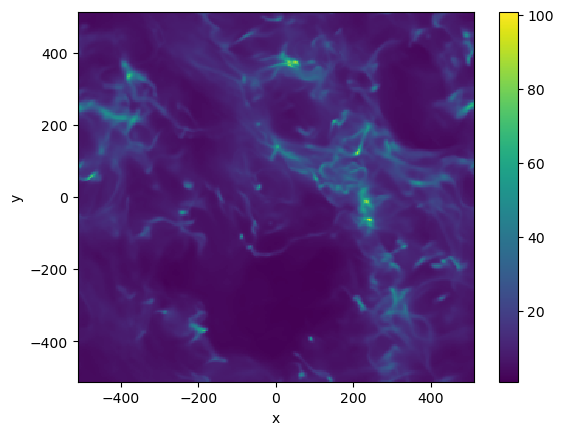

In [13]:
# xarray has the "plot" method that interfaces matplotlib, making quick plot easier.
# Although, when you actually need to make paper quality plot, often you need much more customization
# than you can acheive with this simple wrapper.
da.plot()

In [14]:
# now convert the dictionary of numpy.ndarray to the list of xarray.DataArray with a named coordinate
# we can then concatenate to make it 3D array with one axis being field name
da_list=[xr.DataArray(prj["z"][f], coords=[xcc[1],xcc[0]], dims=["y","x"]).assign_coords(field=f) for f in prj["z"].keys()]
da_3D=xr.concat(da_list,dim="field")

In [15]:
da_3D

<xarray.DataArray (field: 8, y: 256, x: 256)> Size: 2MB
array([[[3.7052174e+00, 3.6884987e+00, 3.6789818e+00, ...,
         3.9932821e+00, 3.8888829e+00, 3.8367376e+00],
        [3.6659493e+00, 3.6673276e+00, 3.6854036e+00, ...,
         3.9179382e+00, 3.8109746e+00, 3.7700288e+00],
        [3.5992258e+00, 3.6164973e+00, 3.6726794e+00, ...,
         3.9193335e+00, 3.7960639e+00, 3.7356467e+00],
        ...,
        [3.8333561e+00, 3.7538502e+00, 3.6839955e+00, ...,
         4.2432828e+00, 4.0942922e+00, 3.9424000e+00],
        [3.7792609e+00, 3.7330213e+00, 3.6865306e+00, ...,
         4.2907920e+00, 4.1388211e+00, 3.9963725e+00],
        [3.7335184e+00, 3.7064583e+00, 3.6766398e+00, ...,
         4.1494684e+00, 4.0261021e+00, 3.9374170e+00]],

       [[3.2123075e+00, 3.1915183e+00, 3.1783772e+00, ...,
         3.4642839e+00, 3.3649306e+00, 3.3183339e+00],
        [3.1727736e+00, 3.1647871e+00, 3.1757610e+00, ...,
         3.4013519e+00, 3.3007450e+00, 3.2651570e+00],
        [3.1025279e+00, 3.1081393e+00, 3.1560280e+00, ...,
         3.4121802e+00, 3.2966089e+00, 3.2411349e+00],
...
        [8.9814737e-02, 8.7840565e-02, 8.6130865e-02, ...,
         9.9739954e-02, 9.6217617e-02, 9.2563264e-02],
        [8.8452905e-02, 8.7299287e-02, 8.6164549e-02, ...,
         1.0074806e-01, 9.7271919e-02, 9.3884319e-02],
        [8.7297633e-02, 8.6626954e-02, 8.5901059e-02, ...,
         9.7296171e-02, 9.4484419e-02, 9.2399620e-02]],

       [[6.7829758e-02, 6.7433722e-02, 6.7171171e-02, ...,
         7.4420072e-02, 7.2664231e-02, 7.1573332e-02],
        [6.6899471e-02, 6.6910811e-02, 6.7207426e-02, ...,
         7.2594561e-02, 7.0675485e-02, 6.9802336e-02],
        [6.5650217e-02, 6.5985002e-02, 6.7010410e-02, ...,
         7.2193407e-02, 6.9887429e-02, 6.8628199e-02],
        ...,
        [7.1510121e-02, 6.9414474e-02, 6.7718327e-02, ...,
         8.1053443e-02, 7.8114301e-02, 7.4766874e-02],
        [6.9977835e-02, 6.8717375e-02, 6.7588441e-02, ...,
         8.1276834e-02, 7.8910306e-02, 7.5992912e-02],
        [6.8712711e-02, 6.7987807e-02, 6.7259304e-02, ...,
         7.7816315e-02, 7.5950697e-02, 7.4264482e-02]]], dtype=float32)
Coordinates:
  * y        (y) float64 2kB -510.0 -506.0 -502.0 -498.0 ... 502.0 506.0 510.0
  * x        (x) float64 2kB -510.0 -506.0 -502.0 -498.0 ... 502.0 506.0 510.0
  * field    (field) <U13 416B 'Sigma_gas' 'Sigma_HI' ... 'Sigma_scalar1'

In [16]:
# DataArray cannot be accessed like dictionary
da_3D["Sigma_gas"]

KeyError: 'Sigma_gas'

In [17]:
# but you can use "sel" method
da_3D.sel(field="Sigma_gas")

<xarray.DataArray (y: 256, x: 256)> Size: 262kB
array([[3.7052174, 3.6884987, 3.6789818, ..., 3.993282 , 3.8888829,
        3.8367376],
       [3.6659493, 3.6673276, 3.6854036, ..., 3.9179382, 3.8109746,
        3.7700288],
       [3.5992258, 3.6164973, 3.6726794, ..., 3.9193335, 3.796064 ,
        3.7356467],
       ...,
       [3.8333561, 3.7538502, 3.6839955, ..., 4.243283 , 4.094292 ,
        3.9424   ],
       [3.7792609, 3.7330213, 3.6865306, ..., 4.290792 , 4.138821 ,
        3.9963725],
       [3.7335184, 3.7064583, 3.6766398, ..., 4.1494684, 4.026102 ,
        3.937417 ]], dtype=float32)
Coordinates:
  * y        (y) float64 2kB -510.0 -506.0 -502.0 -498.0 ... 502.0 506.0 510.0
  * x        (x) float64 2kB -510.0 -506.0 -502.0 -498.0 ... 502.0 506.0 510.0
    field    <U13 52B 'Sigma_gas'

In [18]:
# or you can make it to Dataset which can be accessed like a dictionary
ds = da_3D.to_dataset(dim="field")

In [19]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:        (y: 256, x: 256)
Coordinates:
  * y              (y) float64 2kB -510.0 -506.0 -502.0 ... 502.0 506.0 510.0
  * x              (x) float64 2kB -510.0 -506.0 -502.0 ... 502.0 506.0 510.0
Data variables:
    Sigma_gas      (y, x) float32 262kB 3.705 3.688 3.679 ... 4.149 4.026 3.937
    Sigma_HI       (y, x) float32 262kB 3.212 3.192 3.178 ... 3.605 3.485 3.4
    Sigma_H2       (y, x) float32 262kB 8.099e-07 8.62e-07 ... 4.561e-07
    Sigma_HII      (y, x) float32 262kB 0.4929 0.497 0.5006 ... 0.5415 0.5371
    Sigma_e        (y, x) float32 262kB 0.5006 0.5046 0.508 ... 0.5492 0.5446
    EM             (y, x) float32 262kB 0.187 0.1866 0.1863 ... 0.2845 0.2923
    Sigma_scalar0  (y, x) float32 262kB 0.08655 0.08615 ... 0.09448 0.0924
    Sigma_scalar1  (y, x) float32 262kB 0.06783 0.06743 ... 0.07595 0.07426

In [20]:
ds["Sigma_gas"]

<xarray.DataArray 'Sigma_gas' (y: 256, x: 256)> Size: 262kB
array([[3.7052174, 3.6884987, 3.6789818, ..., 3.993282 , 3.8888829,
        3.8367376],
       [3.6659493, 3.6673276, 3.6854036, ..., 3.9179382, 3.8109746,
        3.7700288],
       [3.5992258, 3.6164973, 3.6726794, ..., 3.9193335, 3.796064 ,
        3.7356467],
       ...,
       [3.8333561, 3.7538502, 3.6839955, ..., 4.243283 , 4.094292 ,
        3.9424   ],
       [3.7792609, 3.7330213, 3.6865306, ..., 4.290792 , 4.138821 ,
        3.9963725],
       [3.7335184, 3.7064583, 3.6766398, ..., 4.1494684, 4.026102 ,
        3.937417 ]], dtype=float32)
Coordinates:
  * y        (y) float64 2kB -510.0 -506.0 -502.0 -498.0 ... 502.0 506.0 510.0
  * x        (x) float64 2kB -510.0 -506.0 -502.0 -498.0 ... 502.0 506.0 510.0

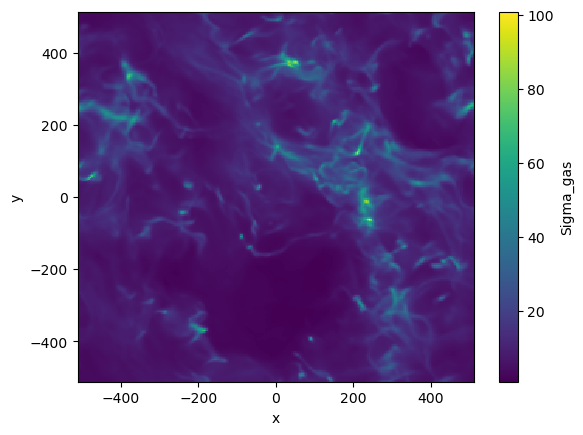

In [21]:
ds["Sigma_gas"].plot()

In [22]:
# it is possible to build a Dataset like a dictionary
ds = xr.Dataset()  # create a empty Dataset
for f in list(prj["z"].keys()):
    ds[f]=xr.DataArray(prj["z"][f], coords=[xcc[1],xcc[0]], dims=["y","x"])

## Shear-peridic domain expansion 

See `expand_domain_shear_periodic.ipynb` for explanation of the process.

In [23]:
from pyathena.util.expand_domain import expand_xy

In [24]:
ds_exp = expand_xy(s,ds,time=prj["time"]) # expanded 2D slices
# here time must be passed and it should be in the code units

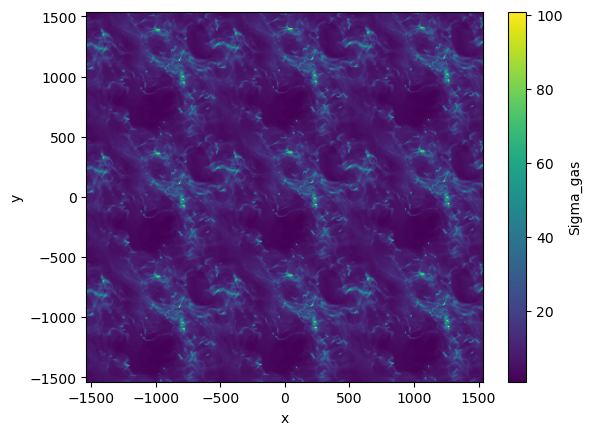

In [25]:
ds_exp["Sigma_gas"].plot()

In [26]:
def prj_to_xarray(sim, num, expand_domain=False):
    prj = sim.read_prj(num)
    # convert to dataset
    ds = xr.Dataset()  # create a empty Dataset
    for f in list(prj["z"].keys()):
        ds[f]=xr.DataArray(prj["z"][f], coords=[xcc[1],xcc[0]], dims=["y","x"])
    # optional domain expansion
    if expand_domain:
        ds_exp = expand_xy(sim,ds,time=prj["time"]) # expanded 2D slices
        # we don't need full 3x domain; 2x domain woudl be suffice
        xmin = sim.domain["le"][0]-sim.domain["Lx"][0]*0.5
        xmax = sim.domain["re"][0]+sim.domain["Lx"][0]*0.5
        ymin = sim.domain["le"][1]-sim.domain["Lx"][1]*0.5
        ymax = sim.domain["re"][1]+sim.domain["Lx"][1]*0.5

        ds = ds_exp.sel(x=slice(xmin,xmax), y=slice(ymin,ymax))
    # return with additional time coordinate
    return ds.assign_coords(time=prj["time"])

In [27]:
num = s.nums[100] # different snapshot
ds = prj_to_xarray(s, num, expand_domain=True)
sp = s.load_starpar_vtk(num)

[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/prj/prj_0300.p
[LoadSimTIGRESSNCR-INFO] [load_starpar_vtk]: R8_4pc_NCR.0300.starpar.vtk. Time: 300.000200


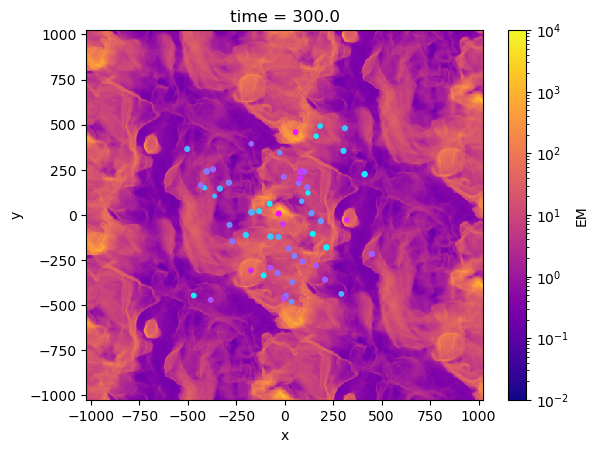

In [28]:
ds["EM"].plot(norm=LogNorm(1.0e-2, 1.0e4),cmap=plt.cm.plasma,)

from pyathena.plt_tools.plt_starpar import scatter_sp, colorbar_sp, legend_sp
scatter_sp(sp, plt.gca(), "z", kpc=False, norm_factor=5, u=s.u, agemax=40)

# Extract cutouts

In [29]:
# now, let's use "read_starpar" method instead of "load_starpar_vtk"
# `load_starpar_vtk` simply read-in the original partcle data only, but
# `read_starpar` does additional processing to return other informations including radiation luminosity
# Since we are only interested in the radiation source, we can use `sp_src` from the return value of `read_starpar`
sp_src=s.read_starpar(num)["sp_src"]

[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/starpar/starpar_0300.p


In [30]:
sp_src

,id,flag,n_ostar,mass,age,mage,metal_mass[0],metal_mass[1],metal_mass[2],metal_mass[3],...,x1,x2,x3,v1,v2,v3,Qi,L_PE,L_LW,L_FUV
227,4794,-1,0,2860.807134,19.485801,19.485801,1802.093750,823.057129,43589.929688,19520.031250,...,37.770485,-372.178864,-21.489437,2.518560,-4.604744,-3.284677,1.070166e+46,6.219040e+04,16082.388491,7.827279e+04
228,4802,-1,0,4458.262101,19.057331,19.057331,2817.671387,1298.218018,76602.593750,29609.828125,...,-403.560455,240.795319,-29.221485,-4.362284,13.204812,6.062549,1.855387e+46,9.973544e+04,26126.206720,1.258616e+05
232,4821,-1,0,3211.921919,17.956690,17.956690,2023.909180,930.459778,19900.150391,36535.425781,...,20.470402,-186.087158,-43.593731,1.382582,-4.632200,-1.217042,1.690041e+46,7.746515e+04,20889.147399,9.835430e+04
233,4822,-1,0,4089.244832,17.950298,17.950298,2568.931152,1126.911133,61256.484375,29638.142578,...,-271.905487,-147.004410,-18.133478,-4.528448,2.185249,0.711824,2.154028e+46,9.867008e+04,26611.925007,1.252820e+05
234,4829,-1,0,3995.830121,17.464274,17.464274,2518.333740,1155.150269,52177.429688,31853.332031,...,5.297656,-448.211578,43.182571,-1.570880,-5.331661,-2.817446,2.334642e+46,9.992161e+04,27320.411692,1.272420e+05
235,4831,-1,0,3466.077852,17.397841,17.397841,2186.120361,1008.515564,27300.625000,36413.074219,...,-36.990063,-322.829834,-32.393734,-4.158813,-6.841733,-1.747370,2.055477e+46,8.708075e+04,23847.174683,1.109279e+05
237,4834,-1,0,3186.910594,17.158218,17.158218,2011.358643,913.736145,35227.832031,28455.767578,...,-432.777924,163.795822,-55.739029,-6.313602,9.600047,4.535953,1.992474e+46,8.146638e+04,22451.948146,1.039183e+05
238,4835,-1,0,1891.980215,17.151396,17.151396,1210.580444,642.062561,25240.031250,14703.291016,...,-173.279160,394.003967,-61.068642,7.587912,10.371926,-3.234186,1.185468e+46,4.839196e+04,13339.582199,6.173154e+04
239,4836,-1,0,3007.578997,17.131698,17.131698,1893.653931,854.818665,42659.335938,22119.826172,...,71.820107,176.636948,26.243704,3.826035,2.284974,3.134255,1.896371e+46,7.705292e+04,21253.339213,9.830626e+04
241,4843,-1,0,4198.164011,16.536594,16.536594,2657.755127,1198.060303,27442.792969,46997.855469,...,-370.566925,252.427124,-27.020527,-2.653504,12.748343,2.447885,3.112896e+46,1.127893e+05,31675.467041,1.444648e+05


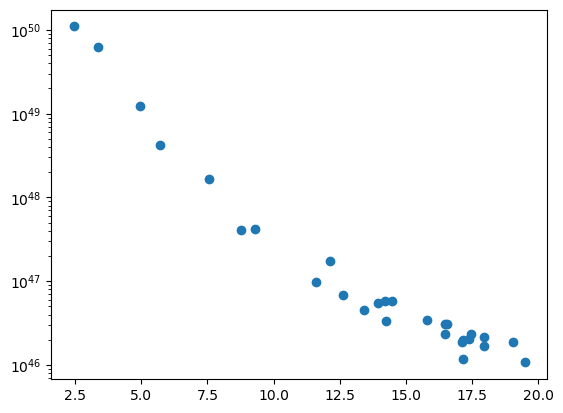

In [31]:
# plot Q_i = ionizing photon number / s as a function of mass-weigthed mean age
plt.plot(sp_src["mage"],sp_src["Qi"],'o')
plt.yscale("log")

In [32]:
# BTW, sp_src is in pandas.DataFrame, which is yet another data type that is convenient for handing table
# see https://pandas.pydata.org/docs/index.html
type(sp_src)

pandas.core.frame.DataFrame

In [33]:
sp_src.sort_values(by="mage")

,id,flag,n_ostar,mass,age,mage,metal_mass[0],metal_mass[1],metal_mass[2],metal_mass[3],...,x1,x2,x3,v1,v2,v3,Qi,L_PE,L_LW,L_FUV
421,5125,0,0,3483.853199,2.449492,2.449492,2190.787842,984.807007,40301.218750,30182.267578,...,-31.541407,7.434621,31.014778,2.994554,5.250551,-1.374610,1.100188e+50,1.482279e+06,710330.226582,2.192609e+06
407,5110,0,0,2492.382810,3.368622,3.368622,1580.741943,778.477051,30886.042969,20551.031250,...,56.084328,458.759979,75.262169,-3.111179,-3.191071,-6.341970,6.230695e+49,9.659875e+05,422395.635398,1.388383e+06
388,5087,-1,0,2590.040914,4.952300,4.952300,1636.397949,771.778564,44588.726562,15178.220703,...,-174.267456,-307.313965,77.617386,-10.088130,1.834243,-3.005828,1.235118e+49,5.415890e+05,239992.177704,7.815812e+05
376,5073,-1,0,2150.326116,5.706799,5.706799,1339.999023,536.190308,17714.529297,22195.357422,...,319.085938,-28.212879,46.345383,-12.042406,-13.256952,2.012271,4.198159e+48,3.538839e+05,146616.372983,5.005003e+05
343,5029,-1,0,4730.488771,7.571851,7.571851,2988.522461,1410.043945,61166.078125,40380.718750,...,78.716545,201.370071,48.742306,7.876468,-5.472081,4.748759,1.670538e+48,4.284387e+05,159117.138012,5.875559e+05
322,4996,-1,0,2574.613810,8.756387,8.756387,1625.557373,764.500977,28217.890625,23103.474609,...,-9.270452,-50.373928,0.830545,4.361458,2.220232,-1.071453,4.035228e+47,1.818647e+05,64461.905604,2.463266e+05
319,4987,-1,0,3708.029463,9.306021,9.306021,2331.465820,1044.151123,66071.031250,23450.365234,...,78.483490,239.771637,51.702484,9.094259,0.745735,2.533488,4.246080e+47,2.371231e+05,82611.748904,3.197349e+05
299,4943,-1,0,2541.765448,11.607736,11.607736,1601.317505,733.170105,15634.479492,28898.361328,...,-6.225313,-465.383972,-8.933892,-2.138515,-1.414646,-5.884503,9.810117e+46,1.148679e+05,37367.425047,1.522354e+05
287,4925,-1,0,5532.327049,12.118430,12.118430,3462.216309,1471.185791,80903.085938,41175.488281,...,92.192307,239.591507,54.370525,9.879035,3.506800,2.309156,1.734830e+47,2.325933e+05,75007.815470,3.076012e+05
281,4915,-1,0,2627.505695,12.619161,12.619057,1656.160278,760.617065,-190102.578125,9101.967773,...,-74.209152,-292.787659,18.216429,-3.206617,0.728227,-4.440367,6.779875e+46,1.037429e+05,32983.257106,1.367261e+05


In [34]:
# Let's take a cutout centered on the youngest star
# selection of pandas array use it's built in method ".loc" and ".iloc"
# see https://pandas.pydata.org/docs/user_guide/indexing.html
sp_sel = sp_src.sort_values(by="mage").iloc[0]

In [35]:
sp_sel

id               5.125000e+03
flag             0.000000e+00
n_ostar          0.000000e+00
mass             3.483853e+03
age              2.449492e+00
mage             2.449492e+00
metal_mass[0]    2.190788e+03
metal_mass[1]    9.848070e+02
metal_mass[2]    4.030122e+04
metal_mass[3]    3.018227e+04
metal_mass[4]   -3.316651e+01
x1              -3.154141e+01
x2               7.434621e+00
x3               3.101478e+01
v1               2.994554e+00
v2               5.250551e+00
v3              -1.374610e+00
Qi               1.100188e+50
L_PE             1.482279e+06
L_LW             7.103302e+05
L_FUV            2.192609e+06
Name: 421, dtype: float64

In [36]:
# to find the nearest cell center position given particle's position
# I used xarray selection method.
# This is to make number of cells in the cutout regular across any
# particle's position. This way, it can be easily concatenated accross different time snapshots
ds_center=ds.sel(x=sp_sel["x1"], y=sp_sel["x2"], method="nearest")
dx=64
dy=64
# get cutout data array
ds_cutout=ds.sel(x=slice(ds_center.x-dx,ds_center.x+dx),
                 y=slice(ds_center.y-dy,ds_center.y+dy))

In [37]:
# note that the number of cells in x and y are now 33x33
ds_cutout

<xarray.Dataset> Size: 35kB
Dimensions:        (y: 33, x: 33)
Coordinates:
  * x              (x) float64 264B -94.0 -90.0 -86.0 -82.0 ... 26.0 30.0 34.0
  * y              (y) float64 264B -58.0 -54.0 -50.0 -46.0 ... 62.0 66.0 70.0
    time           float64 8B 300.0
Data variables:
    Sigma_gas      (y, x) float32 4kB 3.461 3.834 4.044 ... 7.548 6.402 5.652
    Sigma_HI       (y, x) float32 4kB 1.63 1.742 1.612 ... 7.062 5.932 5.167
    Sigma_H2       (y, x) float32 4kB 4.487e-06 4.228e-06 ... 2.576e-06
    Sigma_HII      (y, x) float32 4kB 1.831 2.091 2.431 ... 0.4844 0.4704 0.4845
    Sigma_e        (y, x) float32 4kB 1.851 2.107 2.447 ... 0.506 0.4889 0.5006
    EM             (y, x) float32 4kB 7.644 11.24 15.35 ... 0.3882 0.4955 0.6336
    Sigma_scalar0  (y, x) float32 4kB 0.07807 0.08641 0.09101 ... 0.1425 0.1259
    Sigma_scalar1  (y, x) float32 4kB 0.04841 0.05323 ... 0.07936 0.07071

In [38]:
# assigning new x,y position centered on the nearest cell from the particle
ds_cutout=ds_cutout.assign_coords(
    x=ds_cutout.x.data-ds_center.x.data,
    y=ds_cutout.y.data-ds_center.y.data)

In [39]:
ds_cutout

<xarray.Dataset> Size: 35kB
Dimensions:        (y: 33, x: 33)
Coordinates:
    time           float64 8B 300.0
  * x              (x) float64 264B -64.0 -60.0 -56.0 -52.0 ... 56.0 60.0 64.0
  * y              (y) float64 264B -64.0 -60.0 -56.0 -52.0 ... 56.0 60.0 64.0
Data variables:
    Sigma_gas      (y, x) float32 4kB 3.461 3.834 4.044 ... 7.548 6.402 5.652
    Sigma_HI       (y, x) float32 4kB 1.63 1.742 1.612 ... 7.062 5.932 5.167
    Sigma_H2       (y, x) float32 4kB 4.487e-06 4.228e-06 ... 2.576e-06
    Sigma_HII      (y, x) float32 4kB 1.831 2.091 2.431 ... 0.4844 0.4704 0.4845
    Sigma_e        (y, x) float32 4kB 1.851 2.107 2.447 ... 0.506 0.4889 0.5006
    EM             (y, x) float32 4kB 7.644 11.24 15.35 ... 0.3882 0.4955 0.6336
    Sigma_scalar0  (y, x) float32 4kB 0.07807 0.08641 0.09101 ... 0.1425 0.1259
    Sigma_scalar1  (y, x) float32 4kB 0.04841 0.05323 ... 0.07936 0.07071

In [40]:
def plot_EM_Sigma(ds):
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    plot_kwargs=dict()
    plot_kwargs["Sigma_gas"] = dict(
        label=r"$\Sigma_{\rm gas}\,[M_\odot\,{\rm pc^{-2}}]$",
        norm=LogNorm(1.0e-1, 1.0e2),
        cmap=plt.cm.pink_r,
    )
    plot_kwargs["EM"] = dict(
        label=r"${\rm EM}\,[{\rm cm^{-6}\,pc}]$",
        norm= LogNorm(1.0e-2, 1.0e4),
        cmap=plt.cm.plasma,
    )
    for i, f in enumerate(["EM","Sigma_gas"]):
        ax = axs[i]
        plt.sca(ax)
        im = plt.pcolormesh(
            ds.x,ds.y,ds[f],
            **plot_kwargs[f]
        )
        cbar = plt.colorbar(
            im,
            pad=0.02,
            shrink=0.7,
            location="top",
            label=plot_kwargs[f]["label"])
        ax.set_aspect("equal")
        ax.set_xlabel(r"$x\,[{\rm pc}]$")
        ax.set_ylabel(r"$y\,[{\rm pc}]$")


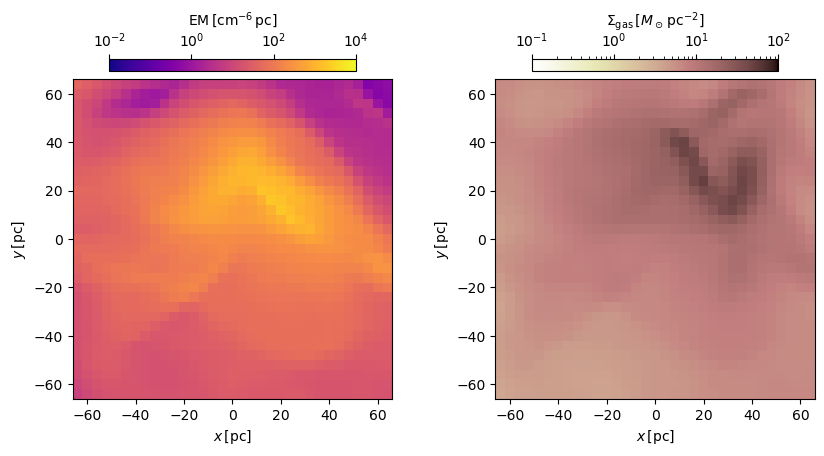

In [41]:
plot_EM_Sigma(ds_cutout)

In [42]:
# make the cutout steps to a function; here I stored additiona information from the particle
def get_cutout(data,sp,dx=64):
    center=data.sel(x=sp["x1"], y=sp["x2"], method="nearest")
    cutout=data.sel(x=slice(center.x-dx,center.x+dx),
                    y=slice(center.y-dx,center.y+dx))
    cutout=cutout.assign_coords(x=cutout.x.data-center.x.data,
                         y=cutout.y.data-center.y.data,
                         x0=center.x.data, y0=center.y.data,
                         xp=sp["x1"], yp=sp["x2"],
                         mage=sp["mage"], Qi=sp["Qi"],
                         mass=sp["mass"]
                        )
    return cutout

In [43]:
# prepare empty dictionary
# I will use particle id for the key
cutouts = dict()
# loop over snapshots (only go through first 20 snapshots for demonstration purpose)
for num in s.nums[:20]:
    ds = prj_to_xarray(s,num,expand_domain=True)
    sp_src = s.read_starpar(num)["sp_src"]
    # only use young source particles
    sp_src = sp_src.loc[lambda df: df["mage"]<10]
    # loop over all young source particles' id within a snapshot
    for id_ in sp_src.id:
        # select corresponding particle
        sp = sp_src.loc[lambda df: df["id"] == id_]
        cutout = get_cutout(ds,sp.iloc[0]) # iloc[0] is to make it a Series rather than 1xncol DataFrame
        if id_ in cutouts:
            # if the dictionary already had the same particle id
            # new cutout will be concatenated
            cutouts[id_] += [cutout]
        else:
            # if this is the first time making a cutout from this id
            # new key is assigned
            cutouts[id_] = [cutout]

[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/prj/prj_0200.p
[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/starpar/starpar_0200.p
[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/prj/prj_0201.p
[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/starpar/starpar_0201.p
[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/prj/prj_0202.p
[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/starpar/starpar_0202.p
[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/prj/prj_0203.p
[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/starpar/starpar_0203.p
[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpf

In [44]:
# now, make the list of dataset into concanated dataset with "time" axis
for id_ in cutouts:
    cutouts[id_]=xr.concat(cutouts[id_],dim="time")

In [45]:
# check particle ids
ids = list(cutouts.keys())
print(ids)

[3511, 3532, 3548, 3554, 3556, 3577, 3598, 3616, 3635, 3674, 3678, 3681, 3696, 3707, 3710, 3721, 3741, 3747, 3748, 3792, 3797, 3873, 3878, 3932, 3942, 3951, 3954, 3963, 3965, 3972, 3975, 3980, 3983]


In [46]:
# visualize cutouts from a selected particle
id_=ids[10]

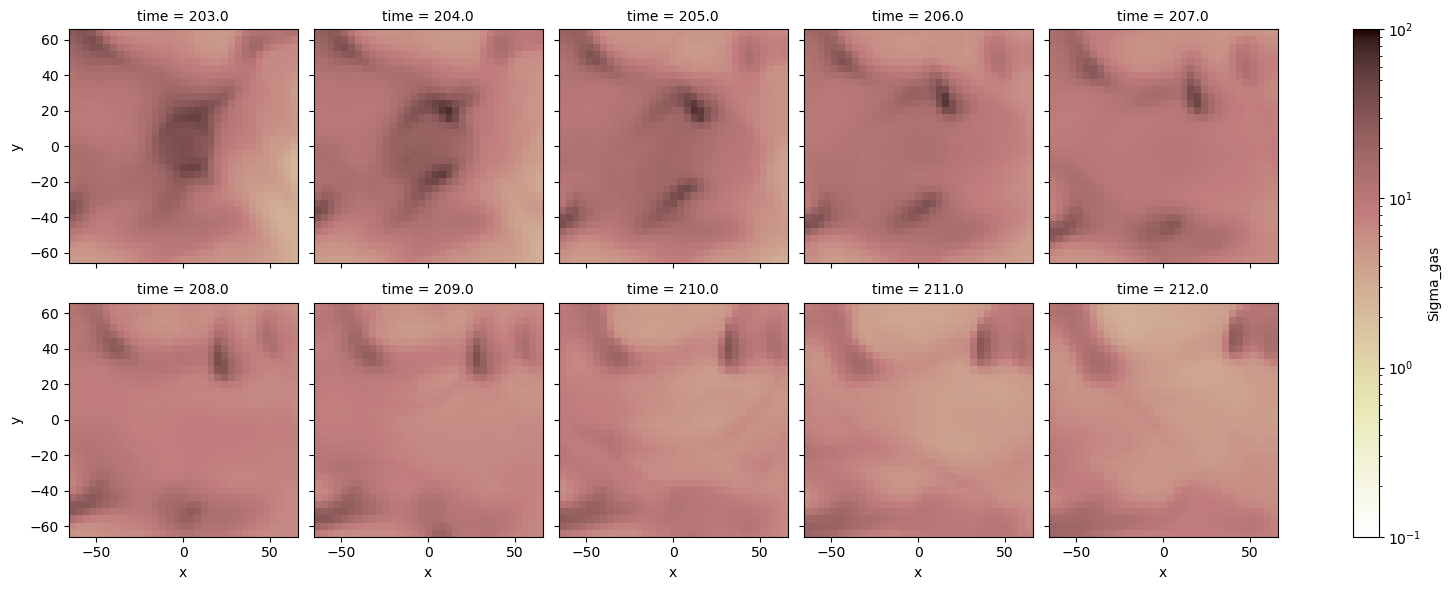

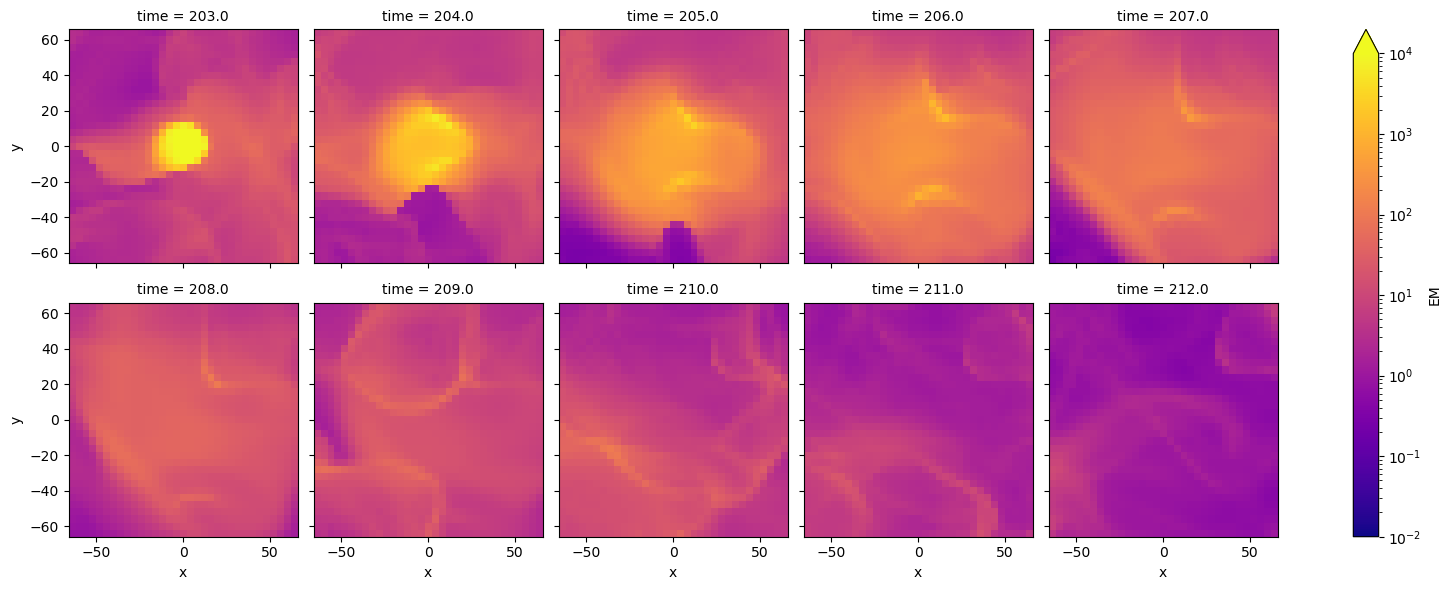

In [47]:
cutouts[id_]["Sigma_gas"].plot(col="time",col_wrap=5,
                                norm=LogNorm(1.0e-1, 1.0e2),
                                cmap=plt.cm.pink_r)
cutouts[id_]["EM"].plot(col="time",col_wrap=5,
                         norm= LogNorm(1.0e-2, 1.0e4),
                         cmap=plt.cm.plasma)

In [48]:
#save each cluster cutouts
outdir = os.path.join(save_dir,"cutouts")
os.makedirs(outdir,exist_ok=True)

for id_ in cutouts:
    outfile = os.path.join(outdir,f"cluster_id{id_}.nc")
    cutouts[id_].to_netcdf(outfile)

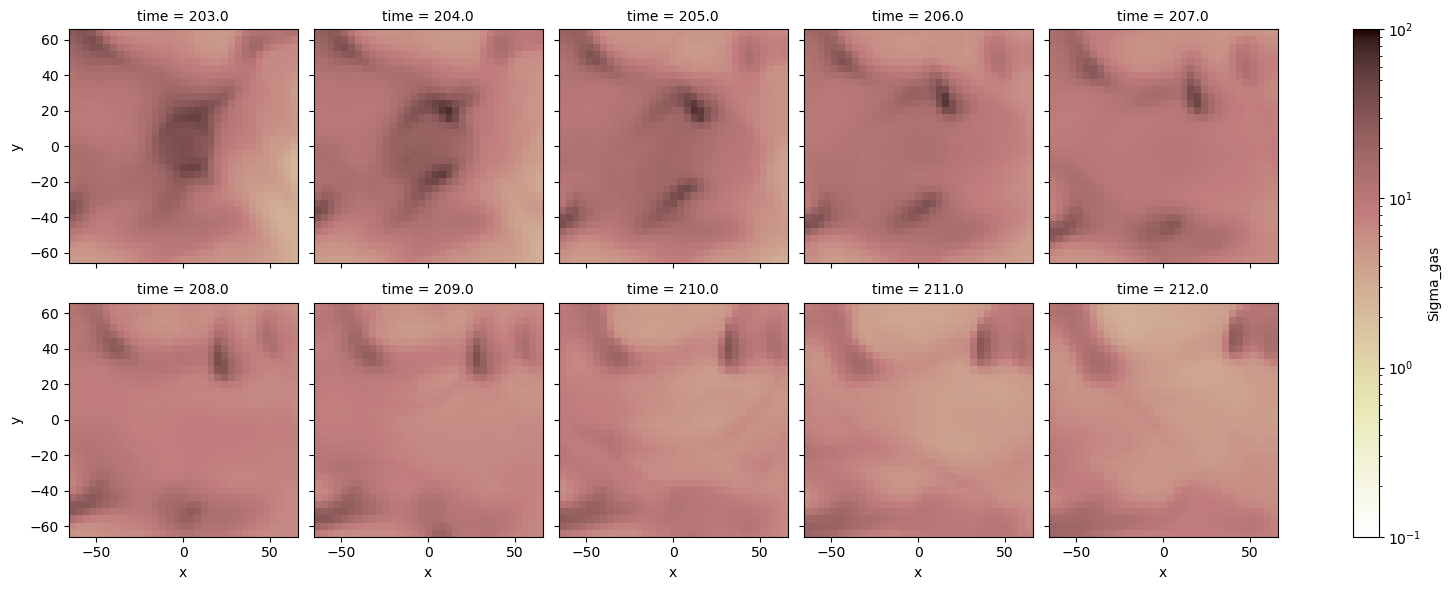

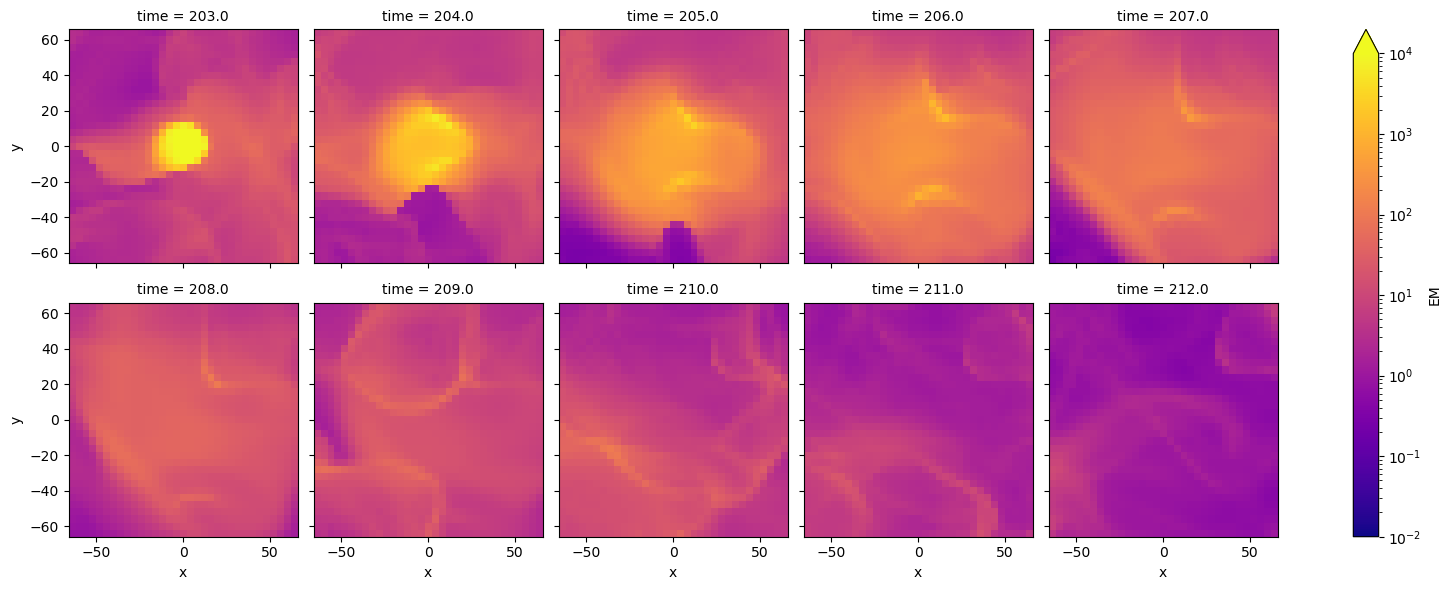

In [49]:
#load back and check
id_=ids[10]
outfile = os.path.join(outdir,f"cluster_id{id_}.nc")

with xr.open_dataset(outfile) as dset:
    dset["Sigma_gas"].plot(col="time",col_wrap=5,
                            norm=LogNorm(1.0e-1, 1.0e2),
                            cmap=plt.cm.pink_r)
    dset["EM"].plot(col="time",col_wrap=5,
                     norm= LogNorm(1.0e-2, 1.0e4),
                     cmap=plt.cm.plasma)